## =Regression Model=

# Imports

In [1]:
import numpy as np
import math

import itertools

import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
path = 'datasets/coins project/neo_full.csv'
data = pd.read_csv(path)
data.head()

name                   date      price     volume   marketCap  \
0  neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1  neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2  neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3  neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4  neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   

   twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0             65687                      3                       136   
1             66436                      3                       123   
2             67419                      3                       127   
3             68640                      3                       171   
4             70173                      2                       165   

   redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0              22013                      703                        0   
1              22277                      580                        0   
2              22821                      963                        0   
3              23713                     1309                        0   
4              24351                     1097                        0   

   alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0      39974            0    279    799          208           39   
1      39580            0    281    805          209           39   
2      39065            0    281    809          209           39   
3      38513            0    282    812          209           39   
4      37837            0    284    816          210           40   

   closedIssues  pullRequestsMerged  pullRequestContributors  \
0            32                   0                       10   
1            32                   0                       10   
2            32                   0                       10   
3            32                   0                       10   
4            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  
0                 0                0                 19  
1                 0                0                 19  
2                 0                0                 19  
3                 0                0                 20  
4                 0                0                 20

# Preprocessing

In [3]:
zero_cleaner_features =['twitterFollowers','redditSubscribers','forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues','pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
features =['price', 'volume', 'marketCap', 'twitterFollowers',
       'redditAveragePosts48h', 'redditAverageComments48h',
       'redditSubscribers', 'redditAccountsActive48h',
        'alexaRank', 'forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues',
       'pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']

def zero_cleaner(column):
    up =0
    for i in range(len(column)):
        val = column[i]
        if column[i] == 0 and up ==0 and i >=1:
            up = column[i-1]
        if column[i] != 0 and up!=0:
            j=i
            ave = (column[i]+up)/2
            while j>=1 and column[j-1] ==0:
                column[j-1] = ave
                j-=1
            up = 0

def target_generator(data):
    b = data['price']
    in_days = 1
    target = 'price_in_{}_day'.format(in_days)
    data[target] = data['price']
    a = data[target]
    for i in range(len(b)):
        if i<len(b)-in_days:
            a[i] = b[i+in_days]
        else:
            a[i] = b[i-5:i].mean()
               
def cleaner(data):
    for feature in zero_cleaner_features:
        zero_cleaner(data[feature])
    target_generator(data) 

In [4]:
cleaner(data)               
data.head()

name                   date      price     volume   marketCap  \
0  neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1  neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2  neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3  neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4  neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   

   twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0             65687                      3                       136   
1             66436                      3                       123   
2             67419                      3                       127   
3             68640                      3                       171   
4             70173                      2                       165   

   redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0              22013                      703                        0   
1              22277                      580                        0   
2              22821                      963                        0   
3              23713                     1309                        0   
4              24351                     1097                        0   

   alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0      39974            0    279    799          208           39   
1      39580            0    281    805          209           39   
2      39065            0    281    809          209           39   
3      38513            0    282    812          209           39   
4      37837            0    284    816          210           40   

   closedIssues  pullRequestsMerged  pullRequestContributors  \
0            32                   0                       10   
1            32                   0                       10   
2            32                   0                       10   
3            32                   0                       10   
4            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  price_in_1_day  
0                 0                0                 19       30.957925  
1                 0                0                 19       23.023138  
2                 0                0                 19       23.674946  
3                 0                0                 20       21.515456  
4                 0                0                 20       30.842616

# Train

In [26]:
def fit_and_predict(data, **params):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []
    
    # For Tuning
    if len(params)>0:
        params = params['params']['params']
        N = params[0]
    else:
        N = 4
    # For Deploy
#     N = 4
        
    pred_min = 0
    
    i=data.shape[0]
    X_train = np.array(range(len(data['price'][i - N:i]))) 
    y_train = np.array(data['price'][i - N:i])
    X_train = X_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)
    pred = regr.predict(np.array(N).reshape(1, -1))
    pred = pred[0][0]
    
    # If the values are < pred_min, set it to be pred_min    
    if pred < pred_min:
        pred = pred_min

    today_price = data.iloc[-1]['price']
    tomorrow_price = pred
    tomorrow_percentage = ((tomorrow_price - today_price) / abs(today_price)) * 100
    return {'today_price': today_price, 'tomorrow_price': tomorrow_price, 'tomorrow_percentage': tomorrow_percentage}
   

In [27]:
fit_and_predict(data)

{'today_price': 11.427525396480426,
 'tomorrow_price': 12.013516981931655,
 'tomorrow_percentage': 5.127895717752759}

# Simulation & Predict

In [29]:
simulation_size = 60
data_size = data.shape[0]
print('data size:{} = train size:{} + test size:{}'.format(data_size, data_size-simulation_size, simulation_size ))
true_values = data[data_size-simulation_size:]['price'].values

def simulation(**params):
    predict_values = []
    for i in range(simulation_size,0,-1):
        today_data = data[:data_size-i]
    
        if len(params):
            tomorrow_predict = fit_and_predict(today_data, params = params)
        else:
            tomorrow_predict = fit_and_predict(today_data)
            
        predict_values.append(tomorrow_predict['tomorrow_price'])
    return predict_values

data size:1057 = train size:997 + test size:60


In [30]:
predict_values = simulation()

# Evaluation

In [31]:
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_rmse(y_true, y_pred): 
    return math.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

def get_bank(y_true, y_pred):
    bank = 100
    coin = 0
    for i, elm in enumerate(y_pred):
        if i == len(y_pred)-1:
            continue
        diff = y_pred[i+1]-y_pred[i]
        true_diff = y_true[i+1]-y_true[i]
        if diff < 0 and coin != 0:
            bank+=coin - y_true[i]
            coin = 0
        if diff>0 and coin==0:
            coin = y_true[i]

    return (bank-100) / 100

def plot_trend(true_trend,pred_trend = [], split_point=0, full_x=False, title=''):
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(true_trend,'blue',label = "true values",alpha=0.6)
    if len(pred_trend) >0:
        plt.plot(pred_trend,'red',label ='prediction',alpha=0.6)
    plt.legend(loc="upper left")
    plt.title(title)
    if full_x ==True:
        plt.xticks(range(len(true_trend)))
        plt.grid(True)
    if split_point !=0:
        plt.axvline(x=split_point,linewidth=2.5)
    plt.show()
    
def full_result(true_values,predict_values):
    rmse = get_rmse(true_values,predict_values)
    mape = get_mape(true_values,predict_values)
    bank = get_bank(true_values,predict_values)
    title ='result of {} days of simulation \n\nrmse: {}\nmape: {} \nbank: {} '.format(simulation_size,rmse,mape,bank)
    plot_trend(true_values,predict_values, title = title)

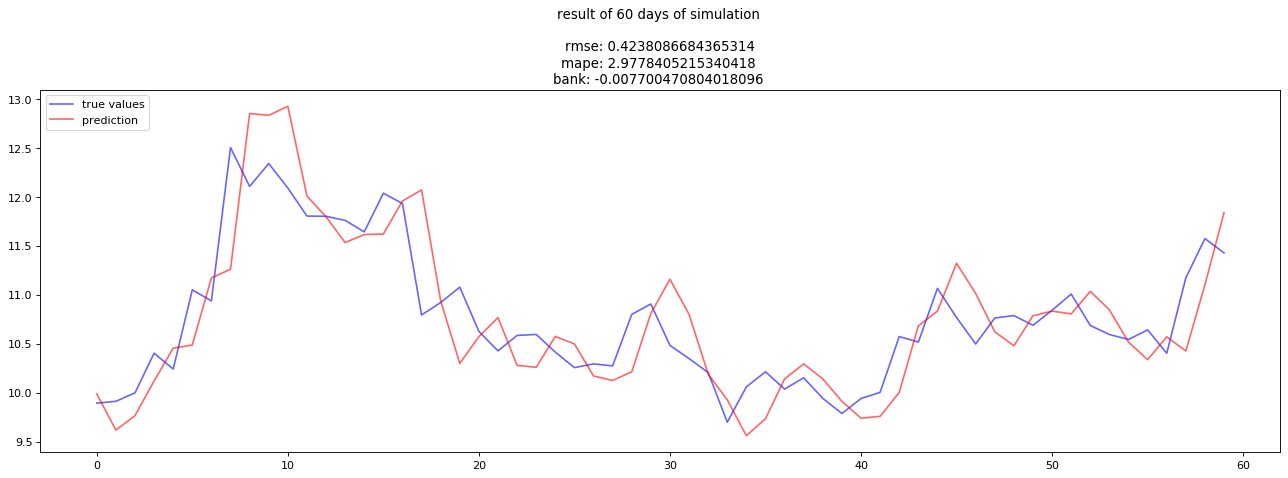

In [32]:
full_result(true_values,predict_values)

# Tune

(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)
(16,)
(17,)
(18,)
(19,)
(20,)
(21,)
(22,)
(23,)
(24,)
(25,)
(26,)
(27,)
(28,)
(29,)
best result with rmse is :	(4,)
best result with mape is :	(5,)


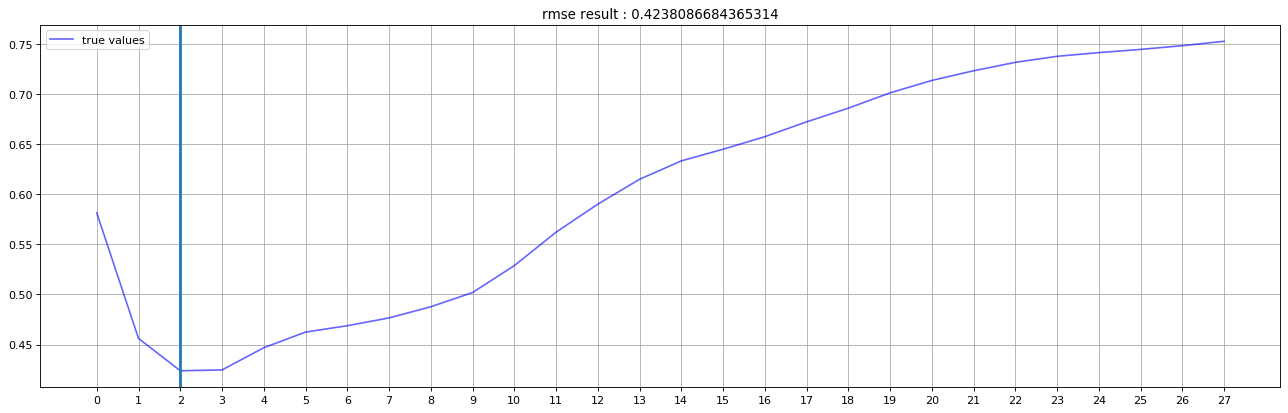

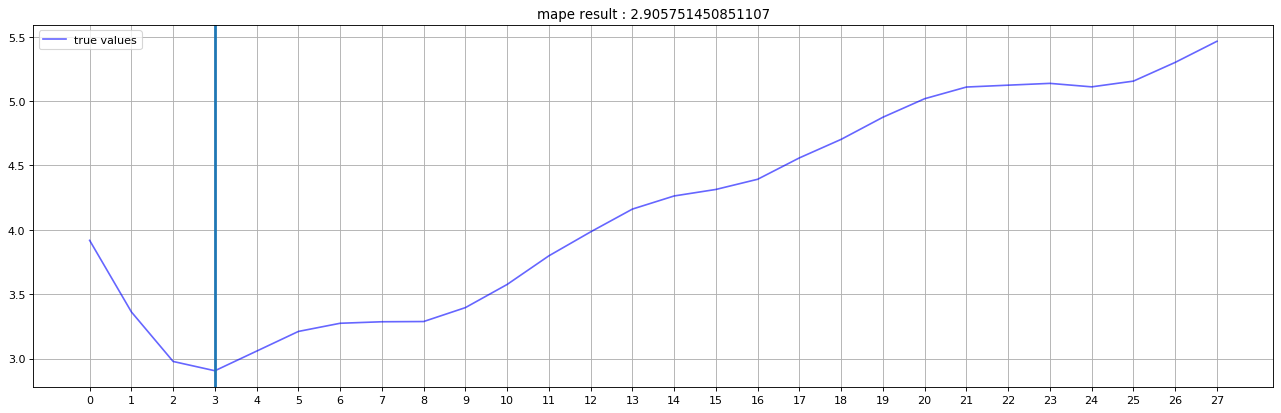

In [28]:
N = range(2,30)
all_features_list = [N]

comb = list(itertools.product(*all_features_list))

rmse_result = []
mape_result = []
min_i_rmse = 0
min_val_rmse = 10000
min_i_mape = 0
min_val_mape = 10000

for i in comb: 
    print(i)
    predict_values = simulation(params = i)
    
    rmse = get_rmse(true_values,predict_values)
    mape = get_mape(true_values,predict_values)
    if min_val_mape > mape:
        min_val_mape = mape
        min_i_mape = i
    if min_val_rmse > rmse:
        min_val_rmse = rmse
        min_i_rmse = i
        
    rmse_result.append(rmse)
    mape_result.append(mape)
print('best result with rmse is :\t{}\nbest result with mape is :\t{}'.format(min_i_rmse, min_i_mape))
plot_trend(rmse_result, split_point =comb.index(min_i_rmse) ,title = 'rmse result : {}'.format(min_val_rmse) ,full_x=True)
plot_trend(mape_result, split_point =comb.index(min_i_mape) ,title = 'mape result : {}'.format(min_val_mape) ,full_x=True)

tune base on rmse


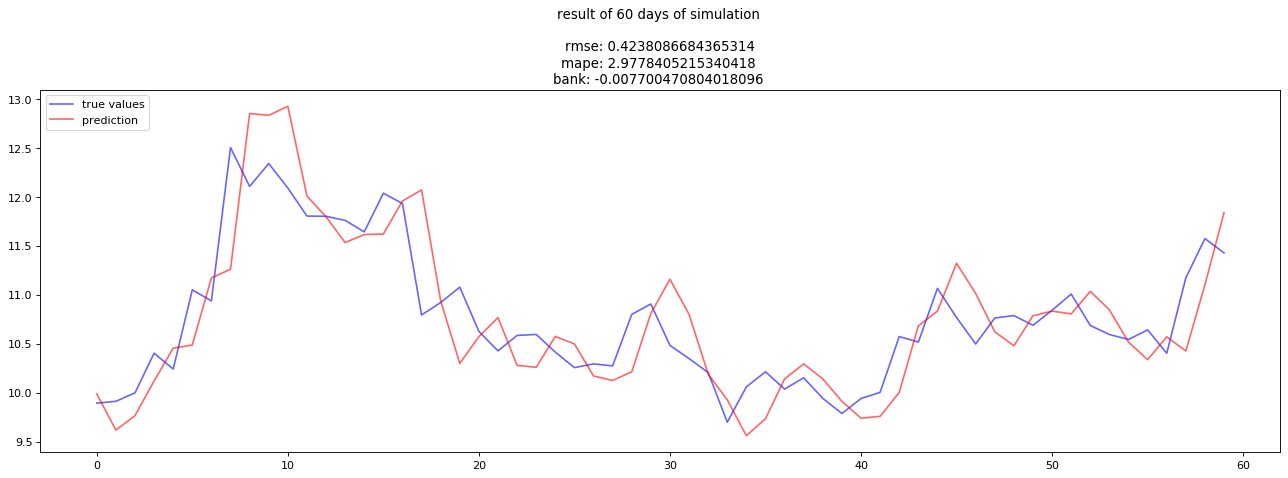

tune base on mape


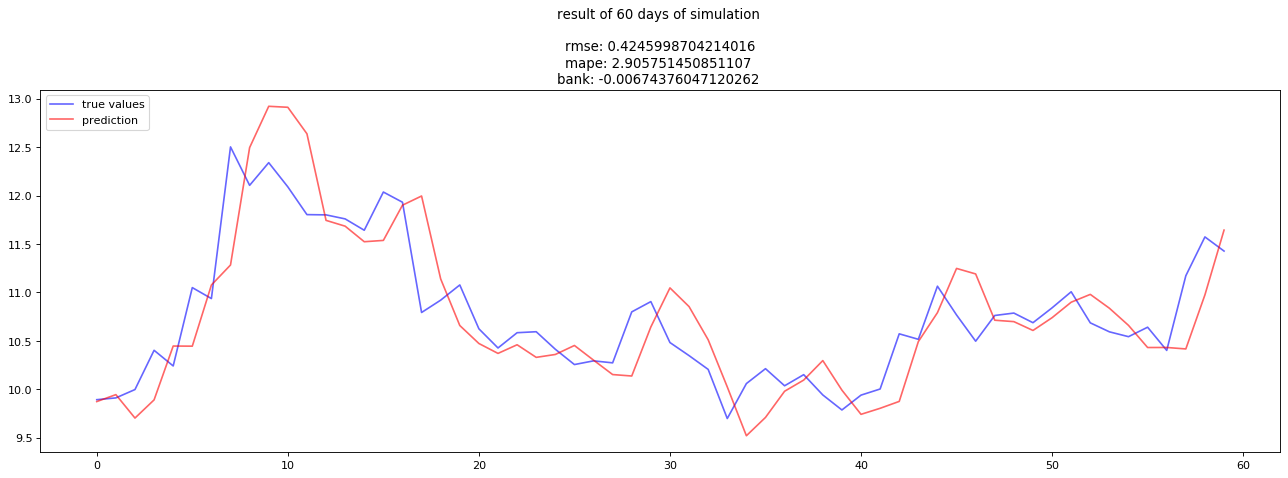

In [25]:
print('tune base on rmse')
predict_values = simulation(params = min_i_rmse)
full_result(true_values,predict_values)

print('tune base on mape')
predict_values = simulation(params = min_i_mape)
full_result(true_values,predict_values)